In [ ]:
# Helpers for multi-sweep comparisons
import pandas as pd
import numpy as np
import wandb

def fetch_sweep_df(sweep_path: str, timeout: int = 60) -> pd.DataFrame:
    """Fetch runs for a W&B sweep path 'entity/project/sweep_id' into a tidy DataFrame.
    Returns DataFrame with columns: run_id, name, state, final/best_r2, model/num_parameters, plus a few config fields.
    """
    api = wandb.Api(timeout=timeout)
    try:
        sweep = api.sweep(path=sweep_path)
    except Exception as e:
        print(f"Failed to load sweep {sweep_path}: {e}")
        return pd.DataFrame()

    recs = []
    for r in sweep.runs:
        s = dict(r.summary or {})
        c = dict(r.config or {})
        num_params = s.get("model/num_params") or s.get("model/num_parameters")
        epoch_loss = s.get("train/epoch_loss")
        recs.append({
            "run_id": r.id,
            "name": r.name,
            "state": r.state,
            "final/best_r2": s.get("final/best_r2"),
            "model/num_parameters": num_params,
            "train/epoch_loss": epoch_loss,
            "model.ssm_dim": c.get("model.ssm_dim"),
            "model.ssm_io_dim": c.get("model.ssm_io_dim"),
            "model.ssm_num_layers": c.get("model.ssm_num_layers"),
            "optimizer.lr": c.get("optimizer.lr"),
            "optimizer.weight_decay": c.get("optimizer.weight_decay"),
            "model.dropout_p": c.get("model.dropout_p"),
            "dataset_args.recording_id": c.get("dataset_args.recording_id"),
        })
    df = pd.DataFrame.from_records(recs)
    if df.empty:
        return df
    df = df.dropna(subset=["final/best_r2", "model/num_parameters"]).copy()
    df = df[df["model/num_parameters"] > 0]
    return df


def compute_best_per_size(df: pd.DataFrame) -> pd.DataFrame:
    """Return the best-performing (max r2) run for each unique parameter count."""
    if df.empty:
        return df
    best = (
        df.sort_values(["model/num_parameters", "final/best_r2"], ascending=[True, False])
          .groupby("model/num_parameters", as_index=False)
          .first()
    )
    return best


def compute_pareto(best_per_size: pd.DataFrame) -> pd.DataFrame:
    """Pareto front where we minimize parameters and maximize r2.
    Expects best_per_size with columns model/num_parameters and final/best_r2.
    """
    if best_per_size.empty:
        return best_per_size
    pts = best_per_size[["model/num_parameters", "final/best_r2"]]
    pts = pts.sort_values(["model/num_parameters", "final/best_r2"], ascending=[True, False]).reset_index(drop=True)
    mask = np.zeros(len(pts), dtype=bool)
    current = -np.inf
    for i, row in pts.iterrows():
        r2 = row["final/best_r2"]
        if r2 > current:
            mask[i] = True
            current = r2
    return pts[mask].copy()


# Helpers to load minimal plot data and reconstruct DataFrames
import json
from pathlib import Path
from typing import Optional, List, Tuple

import pandas as pd


def load_plot_payload(json_path: Path) -> Optional[dict]:
    """Load saved minimal plot data safely. Returns dict or None if not readable."""
    try:
        if not json_path.exists():
            return None
        if json_path.stat().st_size < 2:  # too small to be valid JSON
            return None
        with open(json_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        # Basic schema check
        if not isinstance(payload, dict) or "datasets" not in payload:
            return None
        if not isinstance(payload["datasets"], list):
            return None
        return payload
    except Exception as e:
        print(f"Failed to load JSON from {json_path}: {e}")
        return None


def payload_to_results(payload: dict) -> List[Tuple[str, pd.DataFrame, pd.DataFrame]]:
    """Convert payload into list of (label, best_df, pareto_df) tuples."""
    out = []
    for ds in payload.get("datasets", []):
        label = ds.get("label", "unknown")
        b = ds.get("best_per_size", {})
        p = ds.get("pareto", {})
        best_df = pd.DataFrame({
            "model/num_parameters": b.get("params", []),
            "final/best_r2": b.get("r2", []),
        })
        pareto_df = pd.DataFrame({
            "model/num_parameters": p.get("params", []),
            "final/best_r2": p.get("r2", []),
        })
        out.append((label, best_df, pareto_df))
    return out

Loaded cached results from results/pareto_plot_data.json


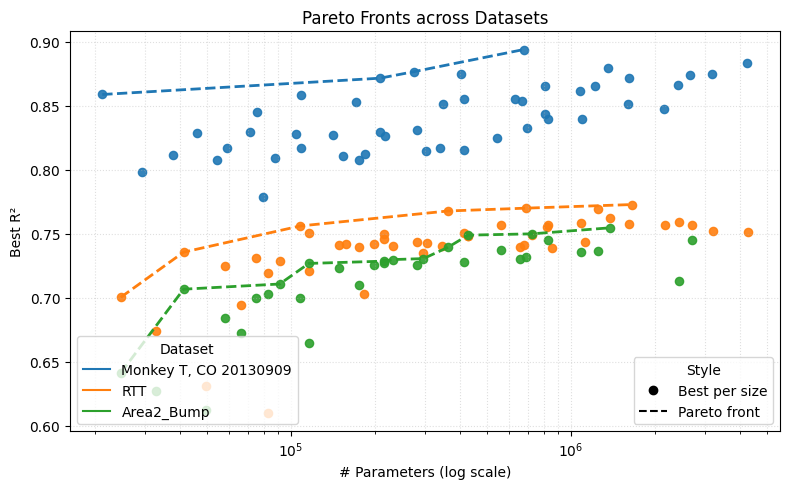

In [3]:
# Compare multiple sweeps: best-per-size and Pareto front overlays
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import json, os

# List of sweeps to compare; add more entries as needed
# Format: (label, "entity/project/sweep_id")
sweeps = [
    ("Monkey T, CO 20130909", "melinajingting-ucl/foundational_ssm_pm_sweep/7liur42y"),
    ("RTT", "melinajingting-ucl/foundational_ssm_rtt_sweep/kwwvplrp"),
    ("Area2_Bump", "melinajingting-ucl/foundational_ssm_area2bump_sweep/ajypyzdr"),
]

# Optional color mapping; unknown labels will default to gray
colors = {
    "Monkey T, CO 20130909": "tab:blue",
    "RTT": "tab:orange",
    "Area2_Bump": "tab:green",
}

# Try loading precomputed minimal results; else fetch and save
json_path = Path("results/pareto_plot_data.json")
payload = load_plot_payload(json_path)
results = []

if payload is not None:
    # Use cached results
    results = payload_to_results(payload)
    # Ensure we have a color for any new labels
    for label, _, _ in results:
        colors.setdefault(label, 'gray')
    print(f"Loaded cached results from {json_path}")
else:
    # Fetch anew from W&B sweeps and compute best/per-size + Pareto
    fetched = []
    for label, path in sweeps:
        df_s = fetch_sweep_df(path)
        df_s.to_csv(f"results/{label.replace(' ', '_')}_sweep_data.csv", index=False)
        if df_s.empty:
            print(f"No data for {label} ({path})")
            continue
        best = compute_best_per_size(df_s)
        pareto = compute_pareto(best)
        fetched.append((label, best, pareto))
        colors.setdefault(label, 'gray')
        print(f"{label}: runs={len(df_s)} best_per_size={len(best)} pareto={len(pareto)}")
    results = fetched

    # Save minimal payload atomically for future runs
    try:
        plot_payload = {"datasets": []}
        for label, best, pareto in results:
            plot_payload["datasets"].append({
                "label": label,
                "best_per_size": {
                    "params": best["model/num_parameters"].tolist(),
                    "r2": best["final/best_r2"].tolist(),
                },
                "pareto": {
                    "params": pareto["model/num_parameters"].tolist(),
                    "r2": pareto["final/best_r2"].tolist(),
                },
            })
        json_path.parent.mkdir(parents=True, exist_ok=True)
        _tmp = json_path.with_suffix(json_path.suffix + ".tmp")
        with open(_tmp, "w", encoding="utf-8") as f:
            json.dump(plot_payload, f)
        os.replace(_tmp, json_path)
        print(f"Saved minimal plot data -> {json_path}")
    except Exception as e:
        print(f"Warning: failed to save minimal plot data: {e}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for label, best, pareto in results:
    c = colors.get(label, None)
    # Best-per-size points (dot)
    ax.scatter(best["model/num_parameters"], best["final/best_r2"], s=35, alpha=0.9, color=c)
    # Pareto line (dash)
    ax.plot(pareto["model/num_parameters"], pareto["final/best_r2"], lw=2, color=c, linestyle="--")

ax.set_xscale("log")
ax.set_xlabel("# Parameters (log scale)")
ax.set_ylabel("Best R²")
ax.set_title("Pareto Fronts across Datasets")
ax.grid(True, which="both", ls=":", alpha=0.4)

# Legends: style legend (dot vs dash) and color legend (dataset name)
style_handles = [
    Line2D([0], [0], marker='o', color='k', linestyle='None', markersize=6, label='Best per size'),
    Line2D([0], [0], color='k', linestyle='--', label='Pareto front'),
]
leg1 = ax.legend(handles=style_handles, title='Style', loc='lower right', frameon=True)
ax.add_artist(leg1)

color_handles = [
    Line2D([0], [0], color=colors.get(label, 'gray'), linestyle='-', label=label)
    for (label, _, _) in results
]
ax.legend(handles=color_handles, title='Dataset', loc='lower left', frameon=True)

plt.tight_layout()
plt.savefig('/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures/pareto_comparison.pdf')
plt.show()


In [ ]:
pareto

Loaded 3 saved sweep CSV(s) from results


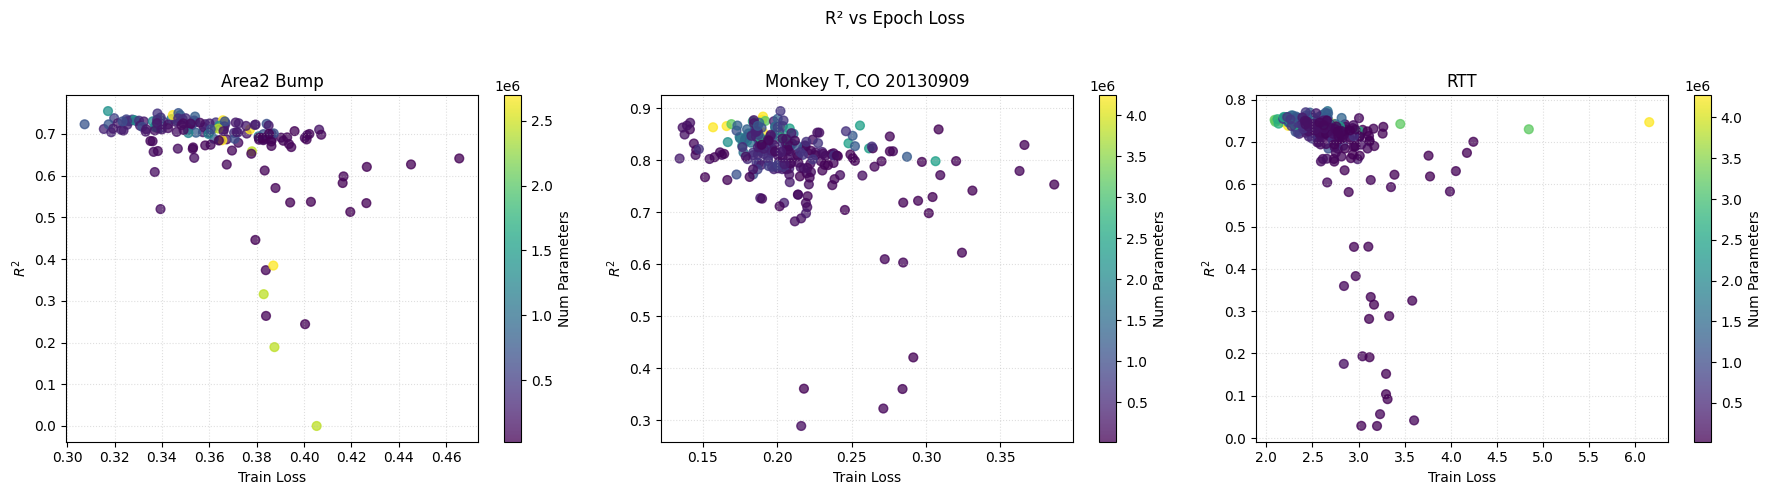

In [9]:
# Compare multiple sweeps: load saved sweep CSVs (preferred) and plot final/best_r2 vs train/epoch_loss
import matplotlib.pyplot as plt
from pathlib import Path
import glob, os

results_dir = Path("results")
# Look for previously saved per-sweep CSVs named like '<label>_sweep_data.csv'
csv_paths = sorted(results_dir.glob('*_sweep_data.csv')) if results_dir.exists() else []
datasets = []
if csv_paths:
    for p in csv_paths:
        try:
            df = pd.read_csv(p)
            label = p.stem.replace('_sweep_data', '').replace('_', ' ')
            df['__label'] = label
            datasets.append((label, df))
        except Exception as e:
            print(f"Failed to read {p}: {e}")
    print(f"Loaded {len(datasets)} saved sweep CSV(s) from {results_dir}")
else:
    # No CSVs saved; try to load minimal payload (but that doesn't contain epoch_loss)
    payload = load_plot_payload(results_dir / 'pareto_plot_data.json')
    if payload is not None:
        print('Found minimal payload but it lacks epoch_loss; consider re-fetching full sweep CSVs or re-running the sweep fetch cell.')
    # As a fallback, fetch full sweeps and save CSVs (requires W&B access)
    for label, path in sweeps:
        df_s = fetch_sweep_df(path)
        if df_s.empty:
            print(f"No data for {label} ({path})")
            continue
        out_path = results_dir / f"{label.replace(' ', '_')}_sweep_data.csv"
        out_path.parent.mkdir(parents=True, exist_ok=True)
        df_s.to_csv(out_path, index=False)
        df_s['__label'] = label
        datasets.append((label, df_s))

# Plot final/best_r2 (y) vs train/epoch_loss (x) — one subplot per sweep
if not datasets:
    print('No sweep data available to plot. Ensure CSVs exist in results/ or W&B is reachable and contains epoch_loss in summaries.')
else:
    n = len(datasets)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    for i, (label, df) in enumerate(datasets):
        ax = axes[0, i]
        if 'final/best_r2' not in df.columns or 'train/epoch_loss' not in df.columns:
            print(f"Skipping {label}: required columns missing (have: {list(df.columns)})")
            ax.text(0.5, 0.5, 'Missing columns', ha='center', va='center')
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        sc = ax.scatter(df['train/epoch_loss'], df['final/best_r2'], s=40, alpha=0.75, c=df['model/num_parameters'])
        ax.set_xlabel('Train Loss')
        ax.set_ylabel(r'$R^2$')
        ax.set_title(label)
        ax.grid(True, ls=':', alpha=0.4)


        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label('Num Parameters')
    plt.suptitle('R² vs Epoch Loss')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('/cs/student/projects1/ml/2024/mlaimon/UCL-ML-Thesis/Writeup/figures/train_vs_test_loss.pdf')
    plt.show()

## Cross-dataset hyperparameter selection: depth × width

Goal: choose SSM depth and width that balance performance across datasets. We:
- Aggregate runs per dataset by (model.ssm_num_layers = depth, model.ssm_dim = width), taking the best R² for each combo.
- Inner-join combos present in all datasets; compute robust metrics per combo:
  - r2_min: minimum R² across datasets (robust worst-case)
  - r2_mean: mean R² across datasets
  - params: median parameter count (proxy; may vary slightly by dataset)
- Select top combos by maximizing r2_min, then r2_mean, then minimizing params.
- Visualize:
  - Scatter grid (depth vs width) colored by r2_min
  - Params vs r2_min with the cross-dataset Pareto front highlighted

Top 10 combos by normalized criteria (max-min then mean, then fewer params):
   depth  width  width_io  r2norm_min  r2norm_mean  params_median
0      4     64       256         0.0     0.304924       692346.0
1      2     64       512         0.0     0.296954      1250490.0
2      2     64       256         0.0     0.282290       362938.0
3      2    128       512         0.0     0.229060      1381754.0
4      4     64       512         0.0     0.192749      2433402.0
5      4    256       256         0.0     0.189016      1086714.0
6      4    128       256         0.0     0.174234       823802.0
7      4    128       512         0.0     0.171690      2695930.0
8      2    256       256         0.0     0.170700       560122.0
9      4    128        64         0.0     0.163266       107834.0


/tmp/ipykernel_501606/3991213291.py:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('viridis')
/tmp/ipykernel_501606/3991213291.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


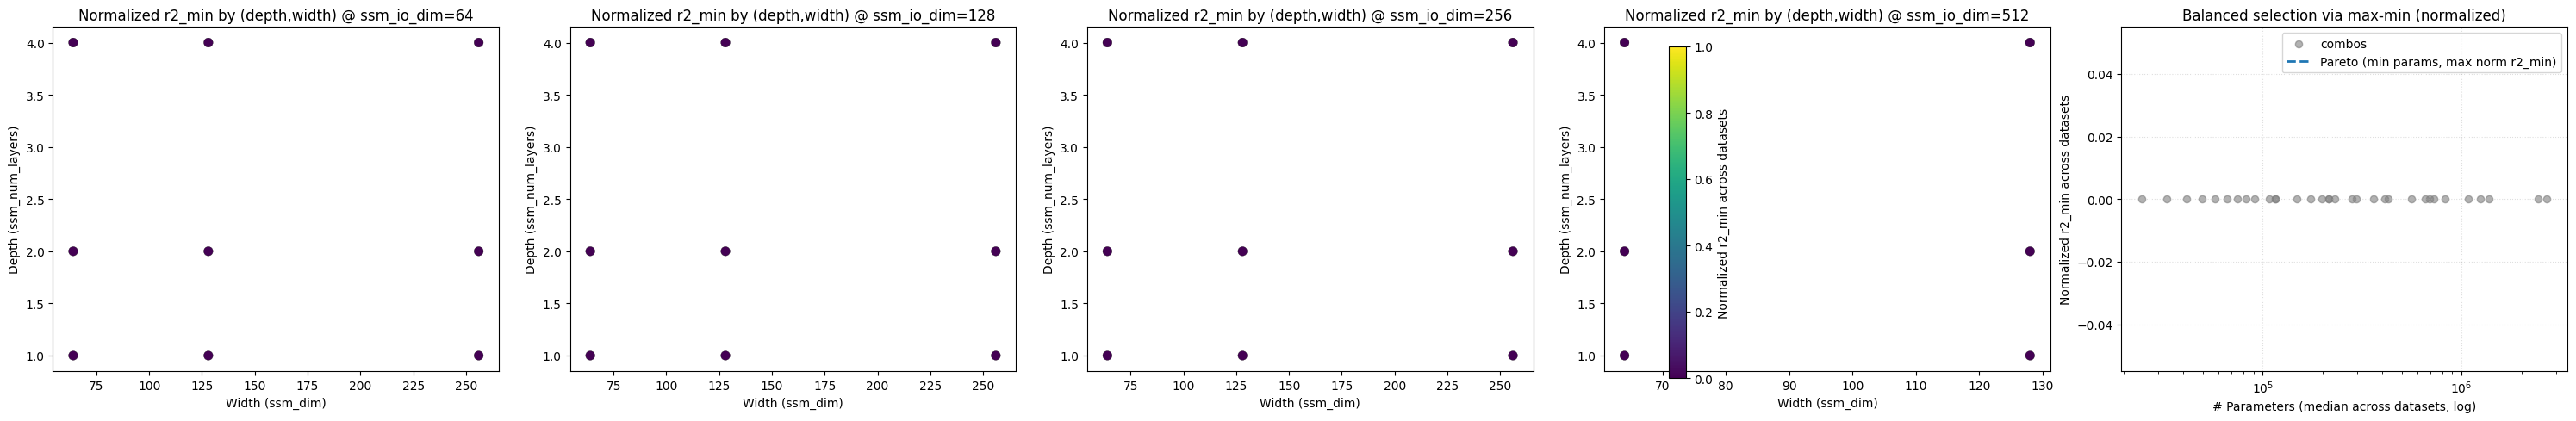

In [ ]:
# Aggregate across datasets by (depth, width, ssm_io_dim) using rank-based fairness and select balanced combos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from pathlib import Path

# Load saved per-sweep CSVs produced earlier
results_dir = Path("results")
csv_paths = sorted(results_dir.glob('*_sweep_data.csv'))
if not csv_paths:
    raise FileNotFoundError("No per-sweep CSVs found. Run the sweep fetching cell first.")

# Map filename to dataset label
def label_from_path(p: Path) -> str:
    return p.stem.replace('_sweep_data', '').replace('_', ' ')

frames = []
for p in csv_paths:
    try:
        df = pd.read_csv(p)
    except Exception as e:
        print(f"Skip {p}: {e}")
        continue
    df = df.copy()
    df['dataset'] = label_from_path(p)
    # Keep useful columns; include both widths (model.ssm_dim and model.ssm_io_dim)
    keep = {
        'dataset': 'dataset',
        'final/best_r2': 'r2',
        'model/num_parameters': 'params',
        'model.ssm_num_layers': 'depth',
        'model.ssm_dim': 'width',
        'model.ssm_io_dim': 'width_io',
    }
    # Ensure columns exist
    missing = [k for k in keep if k not in df.columns]
    if missing:
        print(f"{p.name}: missing columns {missing}; skipping")
        continue
    df = df[list(keep.keys())].rename(columns=keep)
    frames.append(df)

if not frames:
    raise RuntimeError("No valid frames to aggregate.")

all_df = pd.concat(frames, axis=0, ignore_index=True)

# Best R² per (dataset, depth, width, width_io)
best_combo = (
    all_df.sort_values(['dataset','depth','width','width_io','r2'], ascending=[True,True,True,True,False])
          .groupby(['dataset','depth','width','width_io'], as_index=False)
          .first()
)

# Keep combos present in all datasets
present_counts = best_combo.groupby(['depth','width','width_io']).agg(n_dsets=('dataset','nunique')).reset_index()
required = best_combo['dataset'].nunique()
common_combos = present_counts[present_counts['n_dsets'] == required][['depth','width','width_io']]
best_common = best_combo.merge(common_combos, on=['depth','width','width_io'], how='inner')

# Rank/percentile per dataset (scale-free): higher is better
bc = best_common.copy()
bc['r2_rank_pct'] = bc.groupby('dataset')['r2'].rank(method='average', pct=True)

# Cross-dataset rank metrics per (depth,width,width_io)
agg = (bc
       .groupby(['depth','width','width_io'], as_index=False)
       .agg(
           rank_min=('r2_rank_pct','min'),
           rank_mean=('r2_rank_pct','mean'),
           r2_min=('r2','min'),
           r2_mean=('r2','mean'),
           params_median=('params','median')
       )
      )

# Rank combos: maximize min percentile rank, then mean rank, then minimize params
agg = agg.sort_values(['rank_min','rank_mean','params_median'], ascending=[False, False, True]).reset_index(drop=True)
print("Top 10 combos by rank criteria (max-min percentile, then mean, then fewer params):")
print(agg[['depth','width','width_io','rank_min','rank_mean','params_median']].head(10))

# Compute cross-dataset Pareto front on (params_median, rank_min)
pareto = agg.sort_values(['params_median','rank_min'], ascending=[True, False]).copy()
mask = np.zeros(len(pareto), dtype=bool)
cur = -np.inf
for i, r in pareto.iterrows():
    if r['rank_min'] > cur:
        mask[i] = True
        cur = r['rank_min']
pareto_front = pareto[mask]

# Visualize: one heatmap-like scatter per width_io (colored by rank_min in [0,1]) + a Pareto panel on the right
ios = sorted(agg['width_io'].unique())
num_heatmaps = len(ios)
fig, axes = plt.subplots(1, num_heatmaps + 1, figsize=(6 * (num_heatmaps + 1), 5))

# Shared color normalization across heatmaps for ranks
norm = Normalize(vmin=0.0, vmax=1.0)
cm = plt.cm.get_cmap('viridis')

heat_axes = []
for i, io_w in enumerate(ios):
    ax = axes[i]
    heat_axes.append(ax)
    sub = agg[agg['width_io'] == io_w]
    sc = ax.scatter(sub['width'], sub['depth'], c=sub['rank_min'], s=60, cmap=cm, norm=norm, edgecolor='k', linewidth=0.2)
    ax.set_xlabel('Width (ssm_dim)')
    ax.set_ylabel('Depth (ssm_num_layers)')
    ax.set_title(f'Min percentile rank by (depth,width) @ ssm_io_dim={io_w}')

# One shared colorbar for all heatmaps
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=heat_axes)
cb.set_label('Min percentile rank across datasets')

# Rightmost: params vs rank_min with Pareto front
ax = axes[-1]
ax.scatter(agg['params_median'], agg['rank_min'], s=35, alpha=0.6, label='combos', color='tab:gray')
ax.plot(pareto_front['params_median'], pareto_front['rank_min'], color='tab:blue', lw=2, linestyle='--', label='Pareto (min params, max rank_min)')
ax.set_xscale('log')
ax.set_xlabel('# Parameters (median across datasets, log)')
ax.set_ylabel('Min percentile rank across datasets')
ax.set_title('Balanced selection via max-min (rank-based)')
ax.grid(True, ls=':', alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()

Top 10 combos by (max-min R², then mean, then fewer params):
   depth  width  width_io    r2_min   r2_mean  params_median
0      2    128       512  0.754656  0.798852      1381754.0
1      4     64       256  0.732050  0.798728       692346.0
2      4    128       512  0.745178  0.792199      2695930.0
3      2     64       512  0.736862  0.790601      1250490.0
4      4    128       256  0.744953  0.789126       823802.0
5      2     64       256  0.739324  0.786268       362938.0
6      4    256       256  0.735361  0.785314      1086714.0
7      4    256       128  0.727604  0.784360       412794.0
8      2    128       256  0.747967  0.784006       428666.0
9      4     64       128  0.727271  0.782903       215034.0


/tmp/ipykernel_501606/2030391499.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('viridis')


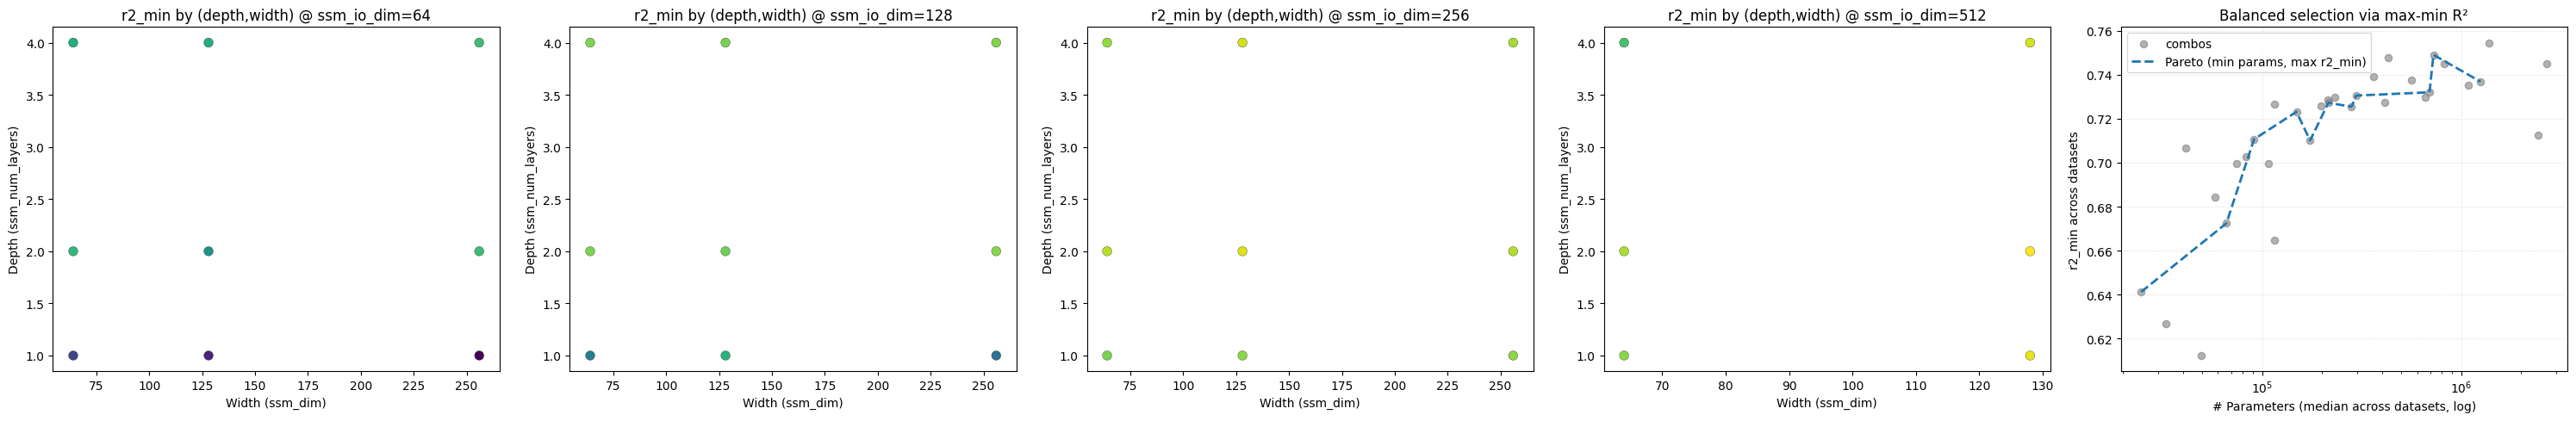

In [ ]:
# Aggregate across datasets by (depth, width, ssm_io_dim) and select balanced combos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from pathlib import Path

# Load saved per-sweep CSVs produced earlier
results_dir = Path("results")
csv_paths = sorted(results_dir.glob('*_sweep_data.csv'))
if not csv_paths:
    raise FileNotFoundError("No per-sweep CSVs found. Run the sweep fetching cell first.")

# Map filename to dataset label
def label_from_path(p: Path) -> str:
    return p.stem.replace('_sweep_data', '').replace('_', ' ')

frames = []
for p in csv_paths:
    try:
        df = pd.read_csv(p)
    except Exception as e:
        print(f"Skip {p}: {e}")
        continue
    df = df.copy()
    df['dataset'] = label_from_path(p)
    # Keep useful columns; include both widths (model.ssm_dim and model.ssm_io_dim)
    keep = {
        'dataset': 'dataset',
        'final/best_r2': 'r2',
        'model/num_parameters': 'params',
        'model.ssm_num_layers': 'depth',
        'model.ssm_dim': 'width',
        'model.ssm_io_dim': 'width_io',
    }
    # Ensure columns exist
    missing = [k for k in keep if k not in df.columns]
    if missing:
        print(f"{p.name}: missing columns {missing}; skipping")
        continue
    df = df[list(keep.keys())].rename(columns=keep)
    frames.append(df)

if not frames:
    raise RuntimeError("No valid frames to aggregate.")

all_df = pd.concat(frames, axis=0, ignore_index=True)

# Best R² per (dataset, depth, width, width_io)
best_combo = (
    all_df.sort_values(['dataset','depth','width','width_io','r2'], ascending=[True,True,True,True,False])
          .groupby(['dataset','depth','width','width_io'], as_index=False)
          .first()
)

# Keep combos present in all datasets
present_counts = best_combo.groupby(['depth','width','width_io']).agg(n_dsets=('dataset','nunique')).reset_index()
required = best_combo['dataset'].nunique()
common_combos = present_counts[present_counts['n_dsets'] == required][['depth','width','width_io']]
best_common = best_combo.merge(common_combos, on=['depth','width','width_io'], how='inner')

# Cross-dataset metrics per (depth,width,width_io)
agg = (best_common
       .groupby(['depth','width','width_io'], as_index=False)
       .agg(r2_min=('r2','min'), r2_mean=('r2','mean'), params_median=('params','median'))
      )

# Rank combos: maximize min R², then mean R², then minimize params
agg = agg.sort_values(['r2_min','r2_mean','params_median'], ascending=[False, False, True]).reset_index(drop=True)
print("Top 10 combos by (max-min R², then mean, then fewer params):")
print(agg.head(10))

# Compute cross-dataset Pareto front on (params_median, r2_min)
pareto = agg.sort_values(['params_median','r2_min'], ascending=[True, False]).copy()
mask = np.zeros(len(pareto), dtype=bool)
cur = -np.inf
for i, r in pareto.iterrows():
    if r['r2_min'] > cur:
        mask[i] = True
        cur = r['r2_min']
pareto_front = pareto[mask]

# Visualize: one heatmap-like scatter per width_io + a Pareto panel on the right
ios = sorted(agg['width_io'].unique())
num_heatmaps = len(ios)
fig, axes = plt.subplots(1, num_heatmaps + 1, figsize=(6 * (num_heatmaps + 1), 5))

# Shared color normalization across heatmaps
norm = Normalize(vmin=agg['r2_min'].min(), vmax=agg['r2_min'].max())
cm = plt.cm.get_cmap('viridis')

heat_axes = []
for i, io_w in enumerate(ios):
    ax = axes[i]
    heat_axes.append(ax)
    sub = agg[agg['width_io'] == io_w]
    sc = ax.scatter(sub['width'], sub['depth'], c=sub['r2_min'], s=60, cmap=cm, norm=norm, edgecolor='k', linewidth=0.2)
    ax.set_xlabel('Width (ssm_dim)')
    ax.set_ylabel('Depth (ssm_num_layers)')
    ax.set_title(f'r2_min by (depth,width) @ ssm_io_dim={io_w}')

# One shared colorbar for all heatmaps
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
# cb = fig.colorbar(sm, ax=heat_axes)
# cb.set_label('r2_min across datasets')

# Rightmost: params vs r2_min with Pareto front
ax = axes[-1]
ax.scatter(agg['params_median'], agg['r2_min'], s=35, alpha=0.6, label='combos', color='tab:gray')
ax.plot(pareto_front['params_median'], pareto_front['r2_min'], color='tab:blue', lw=2, linestyle='--', label='Pareto (min params, max r2_min)')
ax.set_xscale('log')
ax.set_xlabel('# Parameters (median across datasets, log)')
ax.set_ylabel('r2_min across datasets')
ax.set_title('Balanced selection via max-min R²')
ax.grid(True, ls=':', alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()